In [1]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
import argparse
import os

In [2]:
# the below code is an adaptation of SynClock
# https://github.com/charigyang/itsabouttime/tree/main/src
import numpy as np
import cv2
import math
import random

def truefalse(p):
	return random.random() < p

def intminmax(mi, ma):
	return random.choice(range(mi, ma+1))

def minmax(mi, ma):
	return np.random.uniform(mi,ma)

def rand_colour(p_gray=0, p_light=0, p_dark=0, p_red=0):
	xmin = 0; xmax = 255;
	gray = random.random() < p_gray
	if gray:
		x = random.choice(range(xmin,xmax))
		return (x, x, x)
	light = random.random() < p_light
	if light: 
		xmin  = 200;
		x = random.choice(range(xmin,xmax))
		return (x, x, x)
	dark = random.random() < p_dark
	if dark: 
		xmax = 100;
		x = random.choice(range(xmin,xmax))
		return (x, x, x)
	
	xmin = 50; ymin = 50; zmin = 50;
	xmax = 200; ymax = 200; zmax = 200;
	red = random.random() < p_red
	if red:
		xmin = 0; ymin = 0; zmin = 127;
		xmax = 100; ymax = 100; zmax = 255;
	x = random.choice(range(xmin,xmax))
	y = random.choice(range(ymin,ymax))
	z = random.choice(range(zmin,zmax))
	return (x, y, z)

def get_coordinates(cx, cy, r, scale, back_scale, a):
	x1 = (cx + scale*r * np.cos(a * math.pi/180)).astype(int)
	y1 = (cy + scale*r * np.sin(a * math.pi/180)).astype(int)
	x2 = (cx + back_scale*r * np.cos(a * math.pi/180)).astype(int)
	y2 = (cy + back_scale*r * np.sin(a * math.pi/180)).astype(int)
	return (x1, y1), (x2, y2)

def draw_line(img, source, dest, colour, thickness, arrow=False, arrow_scale=None, tip_length=None, rand=False):
	img = cv2.line(img, source, dest, colour, thickness)
	x1, y1 = source
	x2, y2 = dest

	return img

def draw_random_lines(img, cx, cy, r, R, num=3):

	for _ in range(num):
		r1 = intminmax(r,R)
		r2 = intminmax(r,R)
		r3 = intminmax(r,R)
		theta1 = minmax(0, 360)
		theta2 = minmax(0, 360)
		theta3 = minmax(0, 360)
		colour = (0,0,0)
		thickness = intminmax(1,2)

		x1 = (cx + r1 * np.cos(theta1 * math.pi/180)).astype(int)
		y1 = (cy + r1 * np.sin(theta1 * math.pi/180)).astype(int)
		x2 = (cx + r2 * np.cos(theta2 * math.pi/180)).astype(int)
		y2 = (cy + r2 * np.sin(theta2 * math.pi/180)).astype(int)
		x3 = (cx + r3 * np.cos(theta3 * math.pi/180)).astype(int)
		y3 = (cy + r3 * np.sin(theta3 * math.pi/180)).astype(int)
        
		triangle = truefalse(0.5)
		if triangle:
			cv2.line(img, (x1, y1), (x2, y2), colour, thickness)
			cv2.line(img, (x2, y2), (x3, y3), colour, thickness)
			cv2.line(img, (x3, y3), (x1, y1), colour, thickness)
		else:
			img_shadow = cv2.line(img, (x1, y1), (x2, y2), colour, thickness)
	return img


def gen_clock(use_artefacts=True):
	#hyperparameters:
	#canvas
	H = 300
	W = 300
	h = 250 #intminmax(384, 512)
	w = h 
	canvas_background_colour = (0, 0, 0)
	hmax = 0

	#clock shape
	clock_center_coordinates = (h//2, w//2)
	clock_border_thickness = intminmax(0, 1)
	clock_radius = (min(h,w)//2 - clock_border_thickness//2 -1)
	clock_background_colour = (255,255,255) #if truefalse(0.7) else rand_colour(p_gray=0.2)


	#hands
	use_second_hand = truefalse(0.0)
	time_hour = intminmax(1, 12)
	time_minute = intminmax(0, 59)
	time_second = intminmax(0, 59)


	min_scale = minmax(0.5, 1)
	min_back_scale = 0 if truefalse(0.3) else minmax(-0.15, 0.15)
	min_colour = (0,0,0)
	min_thickness = intminmax(1,3)

	hr_scale = minmax(0.3, min_scale)
	hr_back_scale = 0 if truefalse(0.3) else minmax(-0.15, 0.15)
	hr_colour = (0,0,0)
	hr_thickness = intminmax(1,3)

	#circle
	circle_radius = intminmax(1,5)
	circle_colour = (0,0,0)

	#create background
	img = np.zeros((h, w, 3), np.uint8)
	img[:] = canvas_background_colour

	#random lines
	if use_artefacts:
		num_random_lines = intminmax(0, 5)


	#create clock
	img = cv2.circle(img, clock_center_coordinates, clock_radius, clock_background_colour, cv2.FILLED)
	img = cv2.circle(img, clock_center_coordinates, clock_radius, clock_border_thickness)


	#create ticks
	cy, cx = clock_center_coordinates
	r = clock_radius
	a = np.arange(60)*6
	acos = np.cos(a * math.pi/180)
	asin = np.sin(a * math.pi/180)

	#hands

	second = time_second
	a_second = second * 6 - 90

	minute = time_minute + second/60
	a_minute = minute * 6 - 90
	source, dest = get_coordinates(cx, cy, r, min_scale, min_back_scale, a_minute)
	img = draw_line(img, source, dest, min_colour, min_thickness)

	hour = time_hour + minute/60
	a_hour = hour * 30 - 90
	source, dest = get_coordinates(cx, cy, r, hr_scale, hr_back_scale, a_hour)
	img = draw_line(img, source, dest, hr_colour, hr_thickness)
	
	if use_artefacts:
		img = draw_random_lines(img, cx, cy, circle_radius, r, num=num_random_lines)

	#circle
	img = cv2.circle(img, clock_center_coordinates, circle_radius, circle_colour, cv2.FILLED)

	return img, time_hour, time_minute

7 : 38


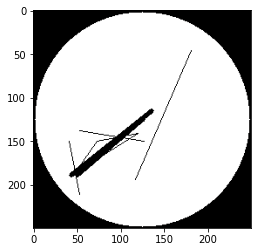

In [3]:
img, hour, minute= gen_clock(use_artefacts=True)
print(hour,":", minute)
plt.imshow(img)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/")

Mounted at /content/drive


In [5]:
# Generating the dataset
#os.chdir("drive/My Drive/")
N = 20000 #size of the training set
dir = 'CAPTCHAs_data/simulated_clocks/' # folder with training set
index_fname = 'index_true.txt'  #log file with time values for each clock

with open(dir+index_fname, 'w') as index_file:
  for n in range(N):
    img, hour, minute= gen_clock(use_artefacts=True)  # generate the clock 250x250
    clock_fname = 'clocks'+str(n+100000)+'.jpeg'
    path_hour = dir+'hour/'+str(hour)+'/'
    path_minute = dir+'minute/'+str(minute)+'/'
    isExistHour = os.path.exists(path_hour)
    isExistMinute = os.path.exists(path_minute)
    if not isExistHour:
      os.makedirs(path_hour)
    cv2.imwrite(path_hour+clock_fname , img) 
    if not isExistMinute:
      os.makedirs(path_minute)
    cv2.imwrite(path_minute+clock_fname , img) 

    # logging the values
    #print('Generating clock for time: {}:{}'.format(hour,minute))
    # Store the index string: the filename, hour, and minute
    index_str = '{}\t{}\t{}\n'.format(clock_fname, hour, minute)
    index_file.write(index_str)

print('Done')

Done


In [6]:
import os
file_count = 0
for i in os.listdir("CAPTCHAs_data/simulated_clocks/hour/"):
  #print(i)
  _, _, files = next(os.walk("CAPTCHAs_data/simulated_clocks/hour/"+i))
  file_count += len(files)
  #print(file_count)
print(file_count)

67252
